<h1>3D Ising Model: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [46]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt, cosh, sinh, log, exp, tanh

#this module contains the statistical functions used throughout the simulation
from my_math import *

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

<h2>Algorithm</h2>

The Monte Carlo algorithm we will use (Holmes-Cerfon 6-9) consists of creating a grid of positive and negative spins, this will be realized as a d-dimensional numpy array of +1 and -1 randomly. This algorithm will apply to any dimension d. We will randomly select a spin and calculate the energy change, $\Delta E$ associated with flipping the spin. The new state will be accepted with probability $Prob=W(\sigma',\sigma)$, where $W(\sigma',\sigma)$ satisfies the detailed balance equation (Grant 41); for our purposes this will be either the Glauber rule or the Metropolis rule. 

$W_{Metropolis}(\sigma',\sigma)=1 \; \Delta E \leq 0, \: e^{\frac{-\Delta E}{k_BT}} \; \Delta E \gt 0$

$W_{Glauber}(\sigma',\sigma)=\frac{1}{2}(1-tanh(\frac{\Delta E}{2k_BT}))$

We will do this N times for N total spins, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation (Grant 45). At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can verify our theoretical expectation of $<m>$. Repeating for diferent temperatures should yield the temperature dependence of $<m>$.

<h2>3-Dimensional Ising Model</h2>

The three-dimensional Ising model consists of an NxNxN rectangular prism of spin sites, $S_i$, pointing in either the positive or negative direction.

$E_{state} = -J\Sigma_{<i,j>}S_iS_j-H\Sigma S_i$

Where <i,j> denotes nearest neighbor interactions with no double counting.

We will take this time to define the critical exponents of the Ising model:

* $\alpha \: : \: C_v \sim |T-T_C|^{-\alpha}, \: H=0$
* $\beta \: : \: m \sim (T_C-T)^{\beta}, \: H=0$
* $\gamma \: : \: \chi \sim |T-T_C|^{-\gamma}, \: H=0$
* $\delta \: : \: H \sim m^{\delta}, \: H\neq0$
* $\eta \: : \: <m(0)m(r)> \sim r^{(-d+2-\eta)}, \: H=0$
* $\nu \: : \: \xi \sim |T-T_C|^{-\nu}, \: H=0$

<h4>Setup</h4>

In [47]:
def init_grid_3d(size):
    """ (int) -> (np.array)
    Creates an 3-dimensional numpy array with size**3 entries of randomly chosen +1 and -1 spins.
    """
    prism = []
    for p in range(size): #number of pages=size
        grid = []
        for i in range(size): #numer of rows=size
            grid.append([random.randrange(-1, 2, 2) for j in range(size)])
        prism.append(grid)
    return np.array(prism)

def total_mag_3d(grid):
    """ (np.array) -> (int)
    Calculates the total magnetization of a 3-dimensional grid of +1/-1 spins.
    """
    tot = 0
    for pages in grid:
        for row in pages:
            tot += sum(row)
    return tot

def mag_per_spin_3d(grid):
    """ (np.array) -> (float)
    Calculates the magnetization per spin of a 3-dimensional grid of +1/-1 spins.
    """
    return total_mag_3d(grid)/len(grid)**3

def energy_3d(grid, H=0):
    """ (np.array, num) -> (num)
    Finds the total energy of a 3-dimensional grid with external field H using nearest neighbors interactions.
    """
    size = len(grid)

    E = 0 #total energy

    for page_idx in range(size):
        for row_idx in range(size):
            for col_idx in range(size):
                #horizontal neighbours with periodic boundary conditions
                E += grid[page_idx][row_idx][col_idx]*grid[page_idx][row_idx][(col_idx+1)%size] 
                E += grid[page_idx][row_idx][col_idx]*grid[page_idx][row_idx][(col_idx-1)%size]

                #vertical neighbours with periodic boundary conditions
                E += grid[page_idx][row_idx][col_idx]*grid[page_idx][(row_idx+1)%size][col_idx] 
                E += grid[page_idx][row_idx][col_idx]*grid[page_idx][(row_idx-1)%size][col_idx]

                #depth neighbours with periodic boundary conditions
                E += grid[page_idx][row_idx][col_idx]*grid[(page_idx+1)%size][row_idx][col_idx] 
                E += grid[page_idx][row_idx][col_idx]*grid[(page_idx-1)%size][row_idx][col_idx]
    
    return -E/2 - H*total_mag_3d(grid)

In [48]:
def energy_change_3d(grid, page_idx, row_idx, col_idx, H=0):
    """ (np.array, int, int, int, float) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position. The change is in units of J.
    H is the external field pointing in either the positive or negative direction also in units of J.
    """
    size = len(grid)

    E = 0 #energy change

    E += 2*H*grid[page_idx][row_idx][col_idx] #change due to external field

    #horizontal neighbours with periodic boundary conditions
    E += 2*grid[page_idx][row_idx][col_idx]*grid[page_idx][row_idx][(col_idx+1)%size] 
    E += 2*grid[page_idx][row_idx][col_idx]*grid[page_idx][row_idx][(col_idx-1)%size]

    #vertical neighbours with periodic boundary conditions
    E += 2*grid[page_idx][row_idx][col_idx]*grid[page_idx][(row_idx+1)%size][col_idx] 
    E += 2*grid[page_idx][row_idx][col_idx]*grid[page_idx][(row_idx-1)%size][col_idx]

    #depth neighbours with periodic boundary conditions
    E += 2*grid[page_idx][row_idx][col_idx]*grid[(page_idx+1)%size][row_idx][col_idx] 
    E += 2*grid[page_idx][row_idx][col_idx]*grid[(page_idx-1)%size][row_idx][col_idx]

    return E

def glauber_3d(grid, page_idx, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 3-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Glauber rule. 
    """
    energy = energy_change_3d(grid, page_idx, row_idx, col_idx, H)
    return 0.5*(1 - tanh(0.5*energy/temp))


def metropolis_3d(grid, page_idx, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 3-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Metropolis rule. 
    """
    energy = energy_change_3d(grid, page_idx, row_idx, col_idx, H)
    if energy <= 0:
        return 1
    return exp(-energy/temp)


def flip_3d(grid, page_idx, row_idx, col_idx, temp, H=0, rule="metropolis"):
    """ (np.array, int, int, int, float, float, str) -> ()
    Flips the spin in grid at site idx with a probability given by the Metropolis or Glauber rule at temperature temp.
    """
    if rule == "glauber":
        prob = glauber_3d(grid, page_idx, row_idx, col_idx, temp, H)
    elif rule == "metropolis":
        prob = metropolis_3d(grid, page_idx, row_idx, col_idx, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.")

    choice = random.uniform(0, 1)
    
    if choice <= prob: #will flip
        grid[page_idx][row_idx][col_idx] *= -1
    #otherwise will not flip and nothing happens


def cycle_3d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    size = len(grid)

    for i in range(size**3): #total number of sites
        page_idx = random.randint(0, size-1)
        row_idx = random.randint(0, size-1)
        col_idx = random.randint(0, size-1)
        flip_3d(grid, page_idx, row_idx, col_idx, temp, H)


def simulation_3d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    size = len(grid)**3 #N Monte Carlo cycles for N sites is one simulation
    for i in range(size):
        cycle_3d(grid, temp, H)

<h4>Simulation</h4>

We will create a three-dimensional numpy array of NxNxN sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit 

In [49]:
def full_sim_3d(N, num_points, num_sim, temperatures, H=0, output="mag"):
    """ (int, int, int, np.array, float) -> (list, list) or (list, list, list, list)
    N: dimensions of grid
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
    output: controls the value we are simulating for ("mag", "energy", or "both")
    """
    if output == "mag":
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>

        for T in temperatures:
            m_at_t = []
            grid = init_grid_3d(N)
            for i in range(num_sim): 
                cycle_3d(grid, T, H)
            for j in range(num_points):
                cycle_3d(grid, T, H)
                m_at_t.append(mag_per_spin_3d(grid))
            magnetizations.append(abs(mean(m_at_t)))
            magnetizations_unc.append(standard_error(m_at_t))
        return magnetizations, magnetizations_unc
    elif output == "energy":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>
        size = N**3

        for T in temperatures:
            e_at_t = []
            grid = init_grid_3d(N)
            for i in range(num_sim): 
                cycle_3d(grid, T, H)
            for j in range(num_points): 
                cycle_3d(grid, T, H)
                e_at_t.append(energy_3d(grid)/size)
            energies.append(mean(m_at_t))
            energies_unc.append(standard_error(m_at_t))
        return energies, energies_unc
    elif output == "both":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>
        size = N**3
        
        for T in temperatures:
            e_at_t = []
            m_at_t = []
            grid = init_grid_3d(N)
            for i in range(num_sim): 
                cycle_3d(grid, T, H)
            for j in range(num_points): 
                cycle_3d(grid, T, H)
                e_at_t.append(energy_3d(grid)/size)
                m_at_t.append(mag_per_spin_3d(grid))
            energies.append(mean(e_at_t))
            energies_unc.append(standard_error(e_at_t))
            magnetizations.append(abs(mean(m_at_t)))
            magnetizations_unc.append(standard_error(m_at_t))
        return energies, energies_unc, magnetizations, magnetizations_unc
    else:
        raise ValueError("The output parameter must be \"mag\", \"energy\", or \"both\".")

<h4>H=0</h4>


In [55]:
#these values will be stored in separate variables so that we may easily change them
N = 5
num_points = 50
num_sim = 3
temperatures_h_0 = np.linspace(0.1, 10, 50) #the range of temperatures over which we will run our simulation

energies, energies_unc, magnetizations, magnetizations_unc = full_sim_3d(N, num_points, num_sim, temperatures_h_0, 0, "both") #run the simulation

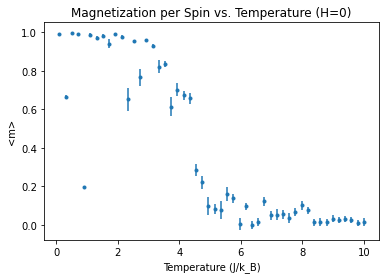

In [56]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation')


plt.xlabel('Temperature (J/k_B)')
plt.ylabel('<m>')
plt.title("Magnetization per Spin vs. Temperature (H=0)")
plt.show()

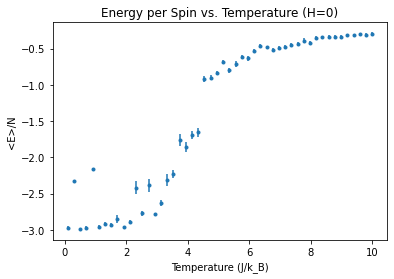

In [57]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation')

plt.title("Energy per Spin vs. Temperature (H=0)")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("<E>/N")
plt.show()

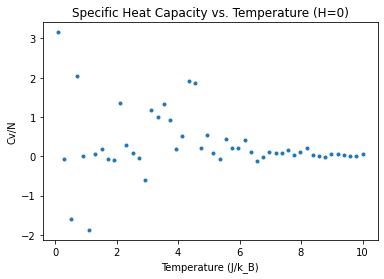

In [58]:
c_v_h_0 = list_derivative(temperatures_h_0, energies)

plt.figure()

plt.plot(temperatures_h_0, c_v_h_0, marker='.', ls='', label='Simulation')

plt.title("Specific Heat Capacity vs. Temperature (H=0)")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("Cv/N")
plt.show()

<h4>H&#8800;0</h4>


In [63]:
#these values will be stored in separate variables so that we may easily change them
N = 5
num_points = 50
num_sim = 3
temperatures = np.linspace(0.1, 20, 50) #the range of temperatures over which we will run our simulation
H = 1

energies, energies_unc, magnetizations, magnetizations_unc = full_sim_3d(N, num_points, num_sim, temperatures, H, "both") #run the simulation

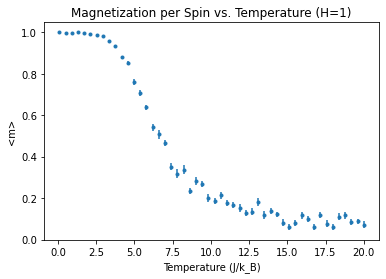

In [64]:
plt.figure()

plt.errorbar(x=temperatures, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation')


plt.xlabel('Temperature (J/k_B)')
plt.ylabel('<m>')
plt.title("Magnetization per Spin vs. Temperature (H=" + str(H) +")")
plt.show()

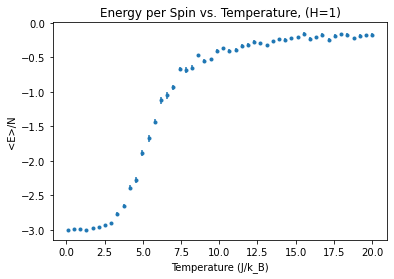

In [65]:
plt.figure()

plt.errorbar(x=temperatures, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation')

plt.title("Energy per Spin vs. Temperature, (H=" + str(H) + ")")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("<E>/N")
plt.show()

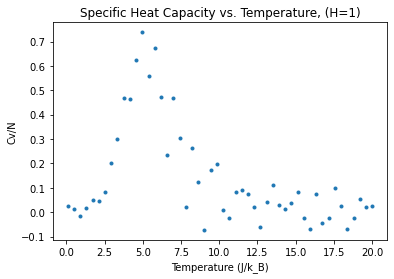

In [66]:
c_v = list_derivative(temperatures, energies)

plt.figure()

plt.plot(temperatures, c_v, marker='.', ls='', label='Simulation')

plt.title("Specific Heat Capacity vs. Temperature, (H=" + str(H) + ")")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("Cv/N")
plt.show()

<h2>Sources</h2>

* Grant, Martin. <em>Dirty tricks for statistical mechanics</em>. 2004.
    * Available here: http://www.physics.mcgill.ca/~grant/559/notes0.91.pdf
* Holmes-Cerfon, Miranda. <em>Lecture 3: Markov Chains (II): Detailed Balance, and Markov Chain Monte Carlo (MCMC)</em>. 2019.
    * Available here: https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf
* Pathria, R. K., and Paul D. Beale. <em>Statistical Mechanics</em>. Elsevier, 2011. 
* Salinas S.R.A. <em>Introduction to Statistical Physics</em>. 2001. Graduate Texts in Contemporary Physics. Springer, New York, NY. https://doi.org/10.1007/978-1-4757-3508-6_13
    * Relevant chapter available here: http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf



